In [27]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from torchvision import datasets, transforms


In [28]:
# Load the image data
csv_path = '../FCRO-Fair-Classification-Orthogonal-Representation/metadata/metadata.csv'
df = pd.read_csv(csv_path)

health = df[["Path", "No Finding"]]
health = health[health["No Finding"]>0]
image_root_path = '../'
images_list = [os.path.join(image_root_path, path) for path in health["Path"].tolist()]
len(images_list)

8145

In [29]:
import torchvision.transforms as tfs
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

transform = tfs.Compose(
    [
        tfs.Resize([224, 224]),
        # tfs.RandomRotation(degrees=(0, 180)),
        tfs.ToTensor(),
        tfs.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dataset = ImageDataset(images_list, transform=transform)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [30]:
for data in dataloader:
    img = data
    break

In [31]:
img.shape

torch.Size([32, 3, 224, 224])

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

os.system('pip install pretrainedmodels')
import pretrainedmodels as ptm


class Densenet121(nn.Module):
    def __init__(self, pretrained):
        super(Densenet121, self).__init__()
        self.model = ptm.__dict__["densenet121"](
            num_classes=1000, pretrained="imagenet" if pretrained else None
        )

    def forward(self, x):
        x = self.model.features(x)
        # print(x.shape)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)

        return x

In [33]:

# from torchvision.models import densenet121

class bvaeEncoder(nn.Module):
    def __init__(self, latent_size):
        super(bvaeEncoder, self).__init__()
        self.encoder = Densenet121(pretrained=True)

        self.feature_dim = self.encoder.model.last_linear.in_features

        self.fc = nn.Linear(self.feature_dim, latent_size)


        # self.densenet = densenet121(pretrained=True)
        # self.latent_size = latent_size
        # self.features = nn.Sequential(*list(self.densenet.children())[:-1])
        self.fc_mu = nn.Linear(self.feature_dim, latent_size)
        self.fc_logvar = nn.Linear(self.feature_dim, latent_size)

    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        # x = self.fc(x)
        
        # x = self.features(x)
        # x = F.relu(x, inplace=True)
        # x = nn.AdaptiveAvgPool2d((1, 1))(x)
        # x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    # def reparameterize(self, mu, logvar):
    #     std = logvar.mul(0.5).exp_()
    #     eps = torch.randn_like(std)
    #     return eps.mul(std).add_(mu)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

In [34]:
encoder = bvaeEncoder(latent_size=128)
z, mu, logvar = encoder(img)

c:\Users\yaoru\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\yaoru\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [35]:
z.shape

torch.Size([32, 128])

In [36]:
class bvaeDecoder(nn.Module):
    def __init__(self, latent_size):
        super(bvaeDecoder, self).__init__()
        self.latent_size = latent_size
        self.fc = nn.Linear(latent_size, 1024)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=7, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 1024, 1, 1)
        x = self.deconv(x)
        return x


In [37]:
encoder = bvaeDecoder(latent_size=128)
x = encoder(z)

In [38]:
x.shape

torch.Size([32, 3, 224, 224])

In [39]:
class BetaVAE(nn.Module):
    def __init__(self, latent_size, beta):
        super(BetaVAE, self).__init__()
        self.encoder = bvaeEncoder(latent_size)
        self.decoder = bvaeDecoder(latent_size)
        self.latent_size = latent_size
        self.beta = beta

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar, z

    def loss_function(self, x_recon, x, mu, logvar):
        recon_loss = F.mse_loss(x_recon, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + self.beta * kl_loss
        return loss

In [40]:
num_epochs = 40
beta=100
BetaVAE = BetaVAE(latent_size=128, beta=beta).cuda()
optimizer = torch.optim.Adam(BetaVAE.parameters(), lr=1e-4)
trainloss = 0
for epoch in range(num_epochs):
    batch = 0
    for data in dataloader:
        
        img = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = BetaVAE(img)
        loss = BetaVAE.loss_function(recon_batch.cuda(), img, mu, logvar)
        
        loss.backward()
        optimizer.step()
        print('Epoch {}, Batch [{}/{}], Loss: {:.4f}'.format(epoch+1, batch+1, int(10000/batch_size), loss.item()))
        batch+=1
    print('*************************************************************')
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    print('*************************************************************')
    torch.save(BetaVAE.state_dict(), 'model_weights_beta{}_epoch{}.pth'.format(beta, epoch+1))

Epoch 1, Batch [1/312], Loss: 8265707.0000
Epoch 1, Batch [2/312], Loss: 8266347.0000
Epoch 1, Batch [3/312], Loss: 8412798.0000
Epoch 1, Batch [4/312], Loss: 8226563.0000
Epoch 1, Batch [5/312], Loss: 8244713.5000
Epoch 1, Batch [6/312], Loss: 8330208.5000
Epoch 1, Batch [7/312], Loss: 8274900.5000
Epoch 1, Batch [8/312], Loss: 8272960.5000
Epoch 1, Batch [9/312], Loss: 8389903.0000
Epoch 1, Batch [10/312], Loss: 8280430.5000
Epoch 1, Batch [11/312], Loss: 8285309.0000
Epoch 1, Batch [12/312], Loss: 8211679.0000
Epoch 1, Batch [13/312], Loss: 8459132.0000
Epoch 1, Batch [14/312], Loss: 8220325.5000
Epoch 1, Batch [15/312], Loss: 8332558.5000
Epoch 1, Batch [16/312], Loss: 8180107.5000
Epoch 1, Batch [17/312], Loss: 8280046.0000
Epoch 1, Batch [18/312], Loss: 8283461.5000
Epoch 1, Batch [19/312], Loss: 8182815.0000
Epoch 1, Batch [20/312], Loss: 8205098.5000
Epoch 1, Batch [21/312], Loss: 8197618.0000
Epoch 1, Batch [22/312], Loss: 8177867.5000
Epoch 1, Batch [23/312], Loss: 8293422.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


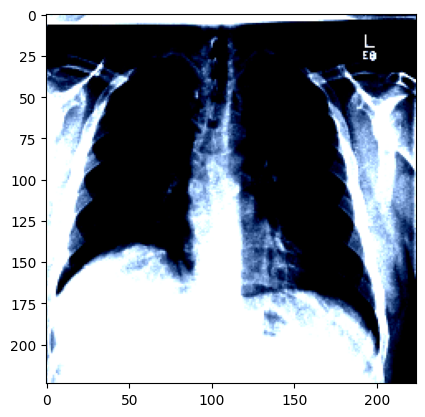

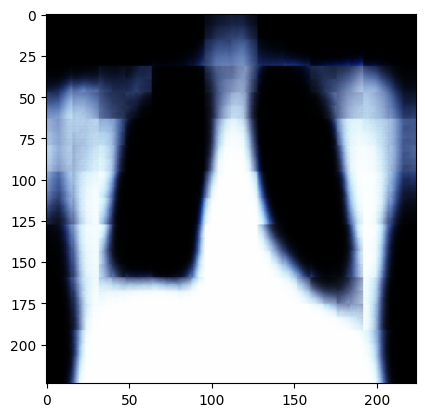

In [45]:
# 加载权重
BetaVAE.load_state_dict(torch.load("model_weights_beta100_epoch10.pth"))
# file = '../CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg'
# img = Image.open(file)
# img_array = np.array(img)

# # 设置评估模式
# model.eval()

# 禁用梯度计算
with torch.no_grad():
    # 得到测试数据
    # test_input = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    # test_input = torch.from_numpy(test_input)
    # print(test_input.shape)
    plt.imshow(data[10,:,:,:].permute(1, 2, 0).numpy())
    plt.show()
  

    
    # 将测试数据传递给模型得到输出
    output,_,_,_ = BetaVAE(torch.unsqueeze(data[10,:,:,:], 0).cuda())
    plt.imshow(output[0,:,:,:].permute(1, 2, 0).cpu().numpy())
    plt.show()
